In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as sgeo
%matplotlib inline

# Disaggregation

The goal of this exercise is to learn how to switch from a zone-based and flow-based simulation to a trip-based setting. The idea is to take the flow matrix generated in the previous exercise and to generate individual trips.

## Disaggregating the flows

Instead of generating the true number of trips, we will only generate a small share to keep the calculations feasible. 

First, we read the generated flow data and the municipality shapes from the previous exercises:

In [2]:
df_flow = pd.read_parquet("flow.parquet")
df_municipalities = gpd.read_parquet("municipalities.parquet")

**Task**: Filter both the municipalities data frame and the flow data frame for the area of Paris (department 75). For the flow data set, make sure that only flows are kept that start within Paris and also end within Paris.

In [3]:
### Insert code here
# ...

df_flow = df_flow.reset_index()
df_flow = df_flow[df_flow["origin_id"].str.startswith("75") & df_flow["destination_id"].str.startswith("75")]

df_municipalities = df_municipalities[df_municipalities["municipality_id"].str.startswith("75")]

**Task**: Now convert the `weight` column (reference flows) or the `model` column (your choice) into a probability by dividing by the total:

In [4]:
### Insert code here
# ...

# df_flow["probability"] = 

df_flow["probability"] = df_flow["weight"] / df_flow["weight"].sum()

**Task**: Next, sample a trip table from the flow data frame, using *pandas*' `sample` method of the data frame, according to the `probability` of each relation. Make sure to pass `replace = True` so you can sample individual entries multiple times. Sample *1,000* trips.

In [5]:
### Insert code here
# ...

# df_trips = 
# 

df_trips = df_flow.sample(1000, weights = "probability", replace = True)

Next, we clean up the trips data frame:

In [6]:
df_trips = df_trips[["origin_id", "destination_id"]]
df_trips.head()

,origin_id,destination_id
15456,75113,75113
18032,75115,75115
18032,75115,75115
19320,75116,75116
10310,75109,75115


## Sampling a departure time

Our next goal is to generate a departure time for each trip. We will only generate trips for the morning peak.

**Task**: Add a departure time to each trip by sampling from the following normal distribution:

$$
t \sim \mathcal{N}(\mu = 8.5, \sigma = 1)
$$

Save the departure time in seconds (seconds after midnight). Set any negative values to zero to avoid computational issues:

In [7]:
### Insert code here
# ...

# df_trips["departure_time"] = 

np.random.seed(0)
df_trips["departure_time"] = np.maximum(0.0, (8.5 + np.random.normal(size = len(df_trips))) * 3600)

**Task**: To make sure, plot a histogram of your generated departure times.

(array([  9.,  20.,  70., 146., 217., 239., 160.,  86.,  38.,  15.]),
 array([ 5.45385695,  6.03440676,  6.61495658,  7.1955064 ,  7.77605621,
         8.35660603,  8.93715585,  9.51770566, 10.09825548, 10.6788053 ,
        11.25935511]),
 <BarContainer object of 10 artists>)

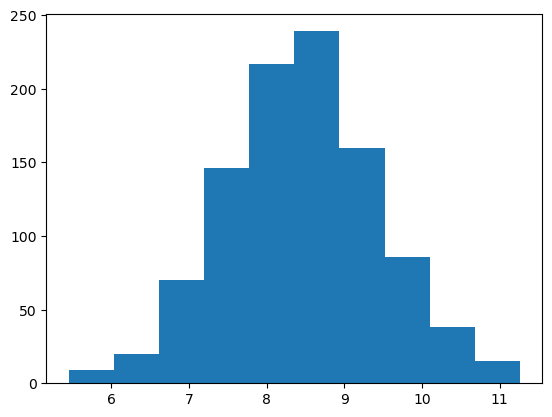

In [8]:
### Insert code here
# ...

plt.hist(df_trips["departure_time"] / 3600)

## Sampling origins and destinations

Next, we want to generate origin and destination points for the trips and show them on a map.

**Task**: We will follow a process that is not the most efficient, but straight-forward to follow. First, merge the municipality data frame onto the trips data frame such that a new column `origin_geometry` is created:

In [9]:
pd.DataFrame({ "origin_id": [], "destination_id": [], "departure_time": [], "origin_geometry": [] })

,origin_id,destination_id,departure_time,origin_geometry


In [10]:
### Insert code here
# ...

# df_trips = pd.merge(df_trips, df_municipalities.rename( # complete # ), on = "origin_id")

df_trips = pd.merge(df_trips, df_municipalities.rename(columns = {
    "municipality_id": "origin_id", "geometry": "origin_geometry"
}), on = "origin_id")

**Task**: Now repeat the same to generate a new column `destination_geometry` for each trip:

In [11]:
### Insert code here
# ...

df_trips = pd.merge(df_trips, df_municipalities.rename(columns = {
    "municipality_id": "destination_id", "geometry": "destination_geometry"
}), on = "destination_id")

Let's clean the data set, we should have the following columns:

In [12]:
df_trips = df_trips[["origin_id", "destination_id", "departure_time", "origin_geometry", "destination_geometry"]]
assert len(df_trips) == 1000

*Geopandas* provides a useful method called `sample_points`, but it only acts on the active *geometry* column of a `GeoDataFrame`. First, we need to convert `df_trips` into a `GeoDataFrame` with `origin_geometry` as the active geometry column:

In [13]:
df_trips = gpd.GeoDataFrame(df_trips, geometry = "origin_geometry", crs = df_municipalities.crs)

Try the following code, it will take the polygon geometry of every trip's origin zone and sample a point from within that zone:

In [14]:
df_trips.sample_points(1)

0      POINT (652423.065 6859572.538)
1      POINT (651951.208 6859094.964)
2      POINT (653569.975 6859416.105)
3      POINT (652090.970 6858256.681)
4      POINT (654632.811 6858422.042)
                    ...              
995    POINT (651474.422 6865424.000)
996    POINT (656275.531 6863123.061)
997    POINT (655507.364 6866081.400)
998    POINT (654275.490 6866280.240)
999    POINT (651898.414 6861737.009)
Name: sampled_points, Length: 1000, dtype: geometry

**Task**: Override the (polygon) `origin_geometry` column in your trip table now with a sampled point from the respective zone:

In [15]:
### Insert code here
# ...

# df_trips["origin_geometry"] = # ...

df_trips["origin_geometry"] = df_trips.sample_points(1)

**Task**: Now, do the same with the destination. First, set the active geometry column of the data frame to `destination_geometry` (see `GeoDataFrame.set_geometry` and then override this column with a randomly sampled point:

In [16]:
### Insert code here
# ...

# df_trips["origin_geometry"] = # ...

df_trips = df_trips.set_geometry("destination_geometry")
df_trips["destination_geometry"] = df_trips.sample_points(1)

Have a look at your data frame. You should see that both `origin_geometry` and `destination_geometry` are of type `POINT`. If they are *exactly* the same, you did something wrong in the previous cells:

In [17]:
df_trips.head()

,origin_id,destination_id,departure_time,origin_geometry,destination_geometry
0,75113,75113,36950.588445,POINT (653326.973 6860016.678),POINT (652412.727 6859730.963)
1,75113,75113,31688.898832,POINT (652716.466 6857637.125),POINT (652148.061 6859826.133)
2,75113,75113,29478.410884,POINT (654817.555 6858863.956),POINT (652121.563 6858233.892)
3,75113,75113,31200.024583,POINT (653381.973 6860105.212),POINT (652567.117 6858893.488)
4,75113,75113,39179.321190,POINT (653581.888 6860088.125),POINT (654361.999 6859225.331)


We will now create a new geometry column which, instead of a `POINT` contains a `LINESTRING`, i.e. a connected line between `N` (in our case 2) points. For that, we make use of the `shapely.geometry` package, which we have imported as `sgeo` (see first cell).

In [18]:
df_trips["geometry"] = [
    sgeo.LineString(od) 
    for od in zip(df_trips["origin_geometry"], df_trips["destination_geometry"])
]

Try to understand the previous cell. What does it do?

**Task**: Set the *active geometry column* of the data frame to `geometry` and plot the data frame. What do you see?

<Axes: >

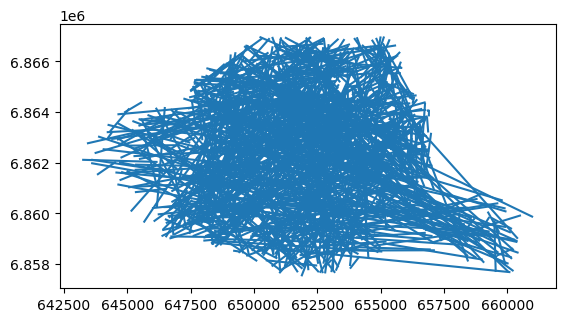

In [19]:
### Insert code here
# ...

df_trips = df_trips.set_geometry("geometry")
df_trips.plot()

**Task**: In this notebook or using QGIS, plot the arrondissements of Paris together with your generated flows.

In [20]:
### Insert code here or use QGIS
# ...


Let's save the generated trips for the next exercise:

In [21]:
df_trips.to_parquet("trips.parquet")

**Congratulations!** You should now be able to disaggregate a flow matrix for your course project (Exercise 3.1).